[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Unsupervised learning with Autoencoder

We first play with MNIST dataset and pieces of code seen during the course.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [3]:
# to be modified if not on colab
ROOT_DIR = Path.home()
root_dir = os.path.join(ROOT_DIR,'data/MNIST/')
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Helper Functions

In [4]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [6]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension?

To find the learning rate, see the documentation for [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [7]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [8]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.122340
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.048029
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.032272
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.030779
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.024821
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.022687
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.021625
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.020779
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.020650
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019362
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.018665
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.019181
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.018281
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.017792
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.017301
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.017593
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.017453
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.017016
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.016472
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.017353
Train Epoch: 6 [51200/60000 (85%)]	

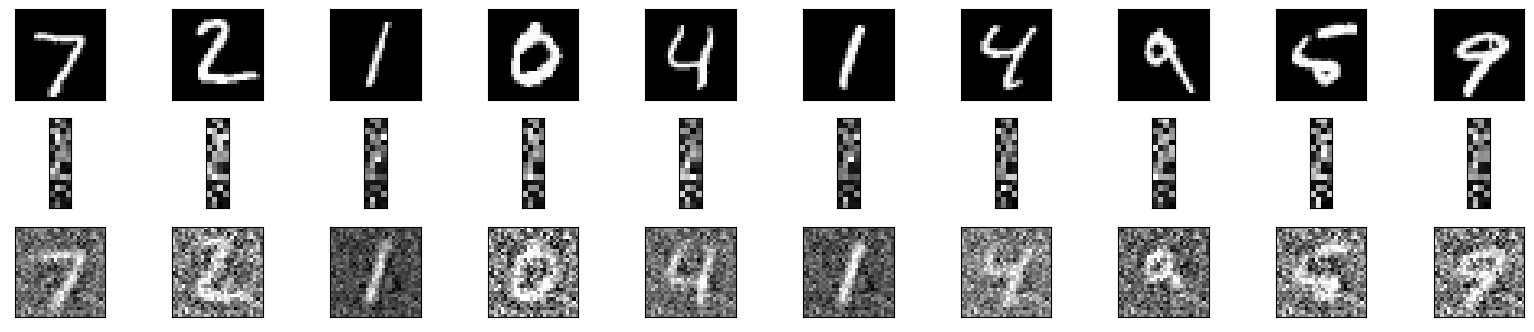

In [9]:
plot_reconstructions(model)

## 1. Exercise: Stacked Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [10]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, encoding_dim), 
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, input_dim),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [12]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.119610
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.045380
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.033857
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.032010
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.027945
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.027066
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.025796
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.023437
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.023262
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022312
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.021274
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.020426
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.020893
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.020597
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.021285
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.019822
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.020667
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.018440
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.018800
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.018502
Train Epoch: 6 [51200/60000 (85%)]	

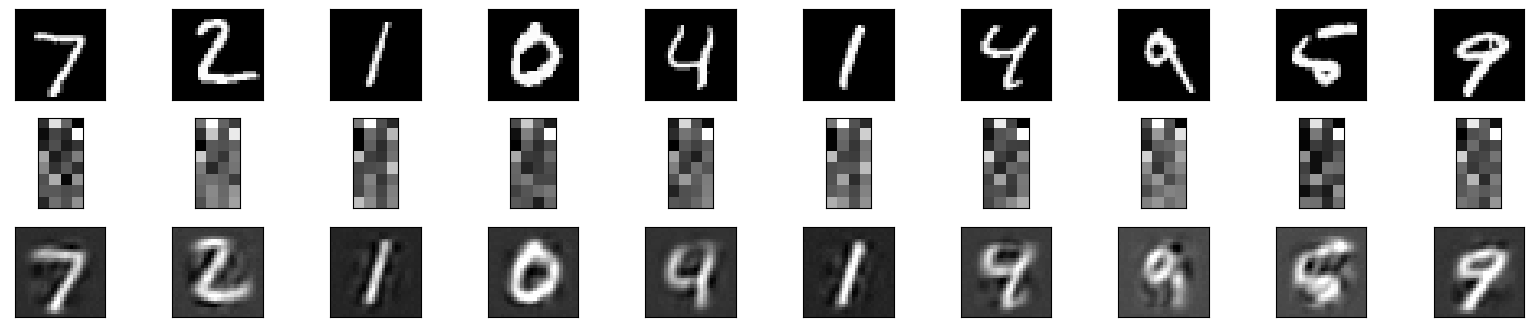

In [13]:
plot_reconstructions(model)

Replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`! You can have a look at the definition of [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy).

In [14]:
model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn =torch.nn.BCEWithLogitsLoss()
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.693661
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.259161
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.234709
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.224174
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.189666
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.173613
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.169985
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.159172
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.151550
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.155992
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.146212
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.143518
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.141305
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.133918
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.132663
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.133407
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.128088
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.127596
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.125760
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.126033
Train Epoch: 6 [51200/60000 (85%)]	

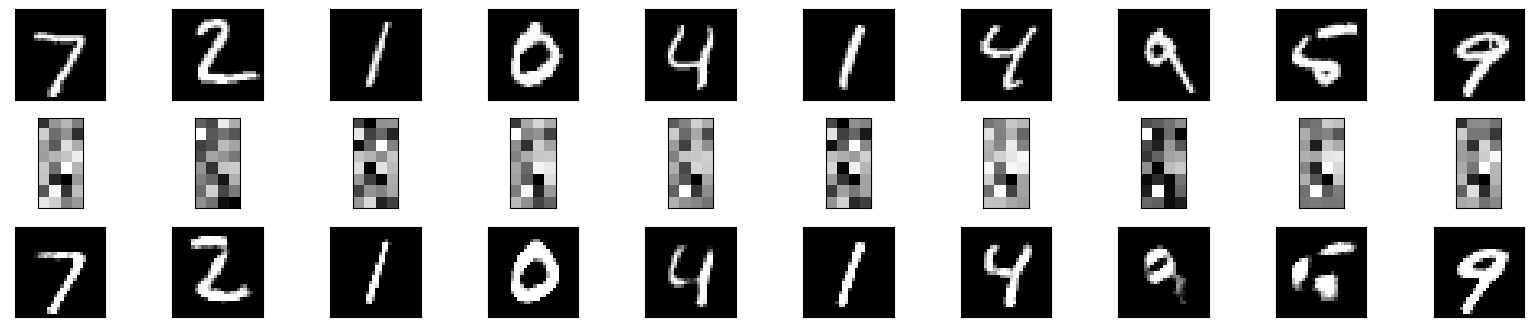

In [15]:
plot_reconstructions(model)

## 2. Optional

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/interp_AE.png)

In [16]:
data, labels = next(iter(test_loader))
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [17]:
encoded_0 = model.encoder(data[1].view(-1,784).to(device))
encoded_1 = model.encoder(data[9].view(-1,784).to(device))

In [18]:
alpha = torch.linspace(0,1,steps=10)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1

In [19]:
decoded_imgs = model.decoder(interp)

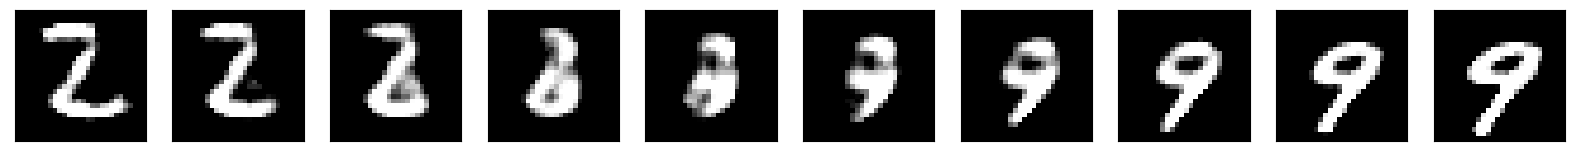

In [20]:
decoded_imgs = to_img(decoded_imgs)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [21]:
#encoded_0 = model.encoder(data[0].view(-1,784).to(device))
#encoded_1 = model.encoder(data[6].view(-1,784).to(device))
n = 100
alpha = torch.linspace(0,1,steps=n)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1
decoded_imgs = model.decoder(interp)
decoded_imgs = to_img(decoded_imgs)

In [22]:
import matplotlib.animation as animation

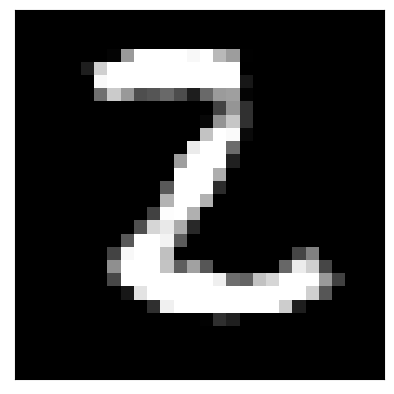

In [23]:
fig, ax = plt.subplots()
ims = []
for i in range(len(decoded_imgs)):
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    im = ax.imshow(decoded_imgs[i], animated=True)
    if i == 0:
        ax.imshow(decoded_imgs[0])  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
#writergif = animation.PillowWriter(fps=30) 
#ani.save("AE_interpolate.gif",writer=writergif)
plt.show()

# 3. Exercise: Implement a denoising AE:


Use previous code and with minimal modifications, transform your AE in a denoising AE. Now, you first apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like: 

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/denoising_AE.png)

The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code and the last line is the denoised digit obtained by your decoder from the code.

In [24]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            #mask = torch.empty_like(data).uniform_() > noise
            #noisy_data = data * mask
            mask = torch.zeros_like(data)
            level = 10
            mask[:,:,-level:,:] = torch.ones(mask.shape[0],1,level,28)
            noisy_data = mask * data
    
            data = data.view([-1, 784]).to(device)
            noisy_data = noisy_data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

In [25]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [26]:
train_denoiser(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer, noise=0.8)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.691750
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.266869
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.243976
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.238556
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.205288
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.199193
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.192245
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.181710
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.181998
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.176252
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.181831
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.174135
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.169205
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.171028
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.165602
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.170564
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.160691
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.161976
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.161571
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.165191
Train Epoch: 6 [51200/60000 (85%)]	

In [27]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits, 
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #
    # your code here to compute
    # noisy_data
    # encoded_imgs
    # decoded_imgs
    #mask = torch.empty_like(data).uniform_() > noise
    #noisy_data = mask * data
    mask = torch.zeros_like(data)
    level = 10
    mask[:,:,-level:,:] = torch.ones(10,1,level,28)
    noisy_data = mask * data
    data = data.to(device)
    noisy_data = noisy_data.to(device)
    noisy_data.requires_grad = False
    data = data.view([-1, 784])
    noisy_data = noisy_data.view([-1,784])
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)
    #
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

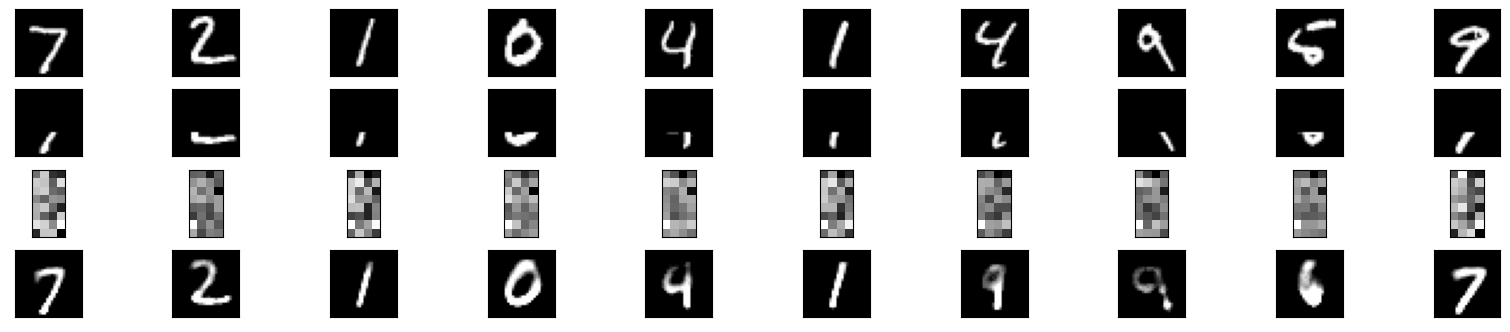

In [28]:
plot_denoising(model, noise=0.8)

# 4. Optional: how to deal with convolutions?

Hint: start by decreasing the size of your image with `Conv2d` by using a `stride` like:

In [29]:
conv = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2)
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 16, 32, 32])

Now use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (or [deconvolution](https://distill.pub/2016/deconv-checkerboard/)) with the same parameters:

In [30]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, stride=2)

In [31]:
convt(y).shape

torch.Size([2, 8, 63, 63])

To get the same size as `x`, play with `output_padding`.

Now, you have all the tools to build a convolutional autoencoder!

In [32]:
class Conv_AutoEncoder(nn.Module):
    def __init__(self):
        super(Conv_AutoEncoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [33]:
def train_model_conv(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            #data = data.view([-1, 784]).to(device)\
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [34]:
model = Conv_AutoEncoder()
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [35]:
data, _ = next(iter(test_loader))
data = data.to(device)

In [36]:
model(data).shape

torch.Size([10, 1, 28, 28])

In [37]:
train_model_conv(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.741344
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.184988
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.089436
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.083861
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.077404
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.072645
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.071753
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.073021
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.069944
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.069676
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.068538
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.069531
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.067690
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.067358
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.067327
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.065691
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.064569
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.067053
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.066373
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.064463
Train Epoch: 6 [51200/60000 (85%)]	

In [38]:
class Conv_Up(nn.Module):
    def __init__(self):
        super(Conv_Up, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 3, stride=3, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=3, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [39]:
model = Conv_Up()
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [40]:
def train_model_up(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(F.avg_pool2d(data, kernel_size = 2))
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [41]:
train_model_up(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.699899
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.275236
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.208102
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.178293
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.129678
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.110307
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.107966
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.099744
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.092488
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.093365
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.088951
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.085323
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.086166
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.085122
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.083457
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.082000
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.082383
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.079957
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.079061
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.079493
Train Epoch: 6 [51200/60000 (85%)]	

In [42]:
def to_img(x, size=28):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, size, size])
    return x

def plot_up_conv(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    noisy_data = F.avg_pool2d(data, kernel_size = 2)
    #data += noise * torch.randn(data.size())
    data = data.to(device)
    noisy_data = noisy_data.to(device)
    
    #data = data.view([-1, 784])
    #noisy_data = noisy_data.view([-1,784])
    noisy_data.requires_grad = False
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data, size=14)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

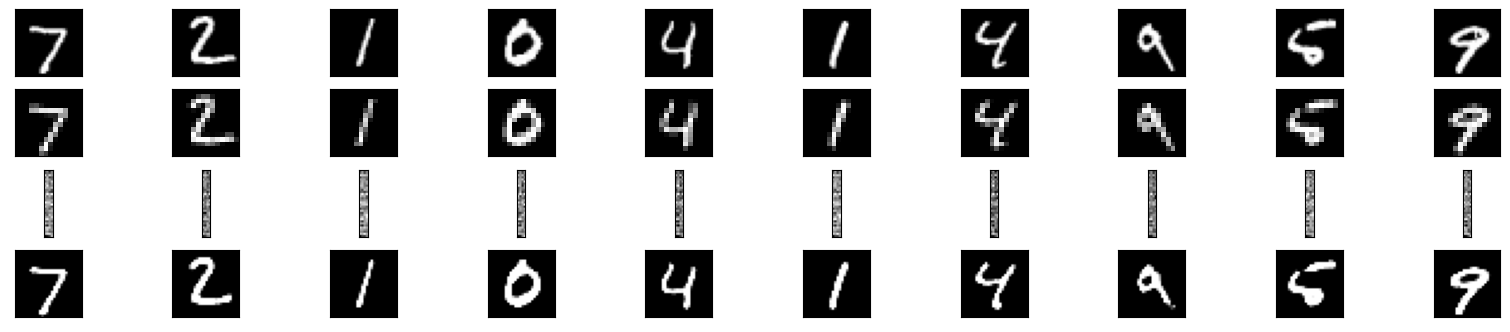

In [43]:
plot_up_conv(model)

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)